In [52]:
import os
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Считывание данных

In [53]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

In [54]:
warnings.filterwarnings("ignore")

In [55]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

In [56]:
data = pd.read_excel("raw_data/Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx")

In [57]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

# Предобработка данных

In [58]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [59]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

In [60]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

# Добавление фич даты

In [61]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

In [62]:
date = date[1:]

In [63]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [64]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [65]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [66]:
data = data.drop(["Дата"], axis=1)

In [67]:
data.isna().sum()

Выработка электроэнергии ТА гр.130                           0
Отпуск тепла из ТО ТА гр.130                                 0
Удельный расход условного топлива на отпуск э/э гр.130       0
Unnamed: 4                                                1090
Предсказание полином 2                                       0
0.033374592702317095                                         0
year                                                         0
month                                                        0
day                                                          0
dtype: int64

In [68]:
data = data[columns_for_predictions + ["day", "month", "year"]]

# Обработка выбросов

In [69]:
# data = data.loc[data[target] < 507]  # данные из predictions/xgb_fuel...
# data = data.loc[data[target] > 100]

# Создание датасета для обучения
## Разделение данных

In [70]:
X = data.drop(target, axis=1)

In [71]:
y = data[target]

In [72]:
out_shape = 1

# Разделение на тренировочную и тестовую выборки

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=30)

# Catboost

In [74]:
model = CatBoostRegressor(iterations=3000)

In [75]:
X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [76]:
model.fit(X_train, y_train, verbose=500);

Learning rate set to 0.01671
0:	learn: 54.3475864	total: 1.86ms	remaining: 5.59s
500:	learn: 11.7405794	total: 285ms	remaining: 1.42s
1000:	learn: 9.0137836	total: 555ms	remaining: 1.11s
1500:	learn: 7.4158494	total: 811ms	remaining: 810ms
2000:	learn: 6.3302753	total: 1.08s	remaining: 538ms
2500:	learn: 5.5427647	total: 1.33s	remaining: 266ms
2999:	learn: 4.9165844	total: 1.59s	remaining: 0us


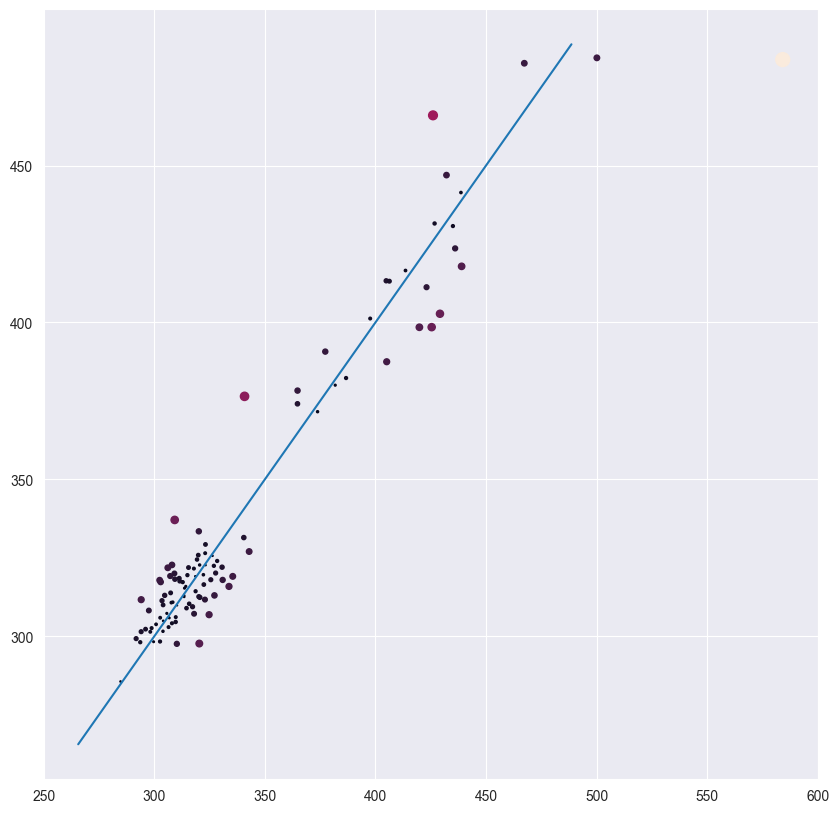

In [77]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [78]:
predictions = np.array(model.predict(X_test))

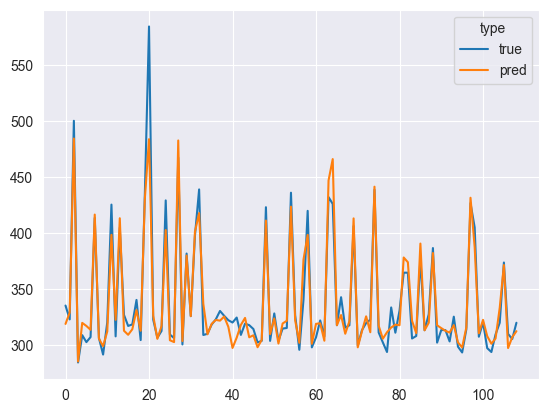

In [79]:
plt.plot(y_test, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("cat_boost_predictions.png");

In [80]:
r2_score(y_test, predictions)

0.918015016464631

In [81]:
for real, pred in zip(y, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 294.82969, pred: 329.28542338516746, diff: 34.455733385167434
real: 305.900684, pred: 484.30241045387356, diff: 178.40172645387355
real: 318.015644, pred: 285.62383942723477, diff: 32.39180457276524
real: 343.910608, pred: 416.54973250405226, diff: 72.63912450405223
real: 361.624141, pred: 306.00762546451415, diff: 55.61651553548586
real: 379.244772, pred: 299.2855122142727, diff: 79.95925978572728
real: 429.177924, pred: 312.42278041060985, diff: 116.75514358939017
real: 437.292468, pred: 398.50956352032665, diff: 38.782904479673334
real: 405.468105, pred: 322.76482394220216, diff: 82.70328105779782
real: 408.603513, pred: 313.0495449525957, diff: 95.55396804740434
real: 412.053563, pred: 309.4412865262715, diff: 102.61227647372851
real: 418.816147, pred: 314.37638889278173, diff: 104.43975810721827
real: 421.140593, pred: 331.4725048017705, diff: 89.6680881982295
real: 422.524854, pred: 313.06115452817846, diff: 109.46369947182154
real: 430.854225, pred: 483.7327242117153, diff

In [82]:
model = CatBoostRegressor(iterations=7001)

In [83]:
model.fit(X, y, verbose=500);

Learning rate set to 0.008531
0:	learn: 54.3683973	total: 1.33ms	remaining: 9.31s
500:	learn: 14.6139642	total: 296ms	remaining: 3.83s
1000:	learn: 11.9317475	total: 581ms	remaining: 3.48s
1500:	learn: 10.3698045	total: 852ms	remaining: 3.12s
2000:	learn: 9.2777908	total: 1.14s	remaining: 2.84s
2500:	learn: 8.4100474	total: 1.39s	remaining: 2.51s
3000:	learn: 7.7223501	total: 1.67s	remaining: 2.23s
3500:	learn: 7.1105236	total: 1.95s	remaining: 1.94s
4000:	learn: 6.6011886	total: 2.22s	remaining: 1.66s
4500:	learn: 6.2061513	total: 2.49s	remaining: 1.39s
5000:	learn: 5.8510320	total: 2.77s	remaining: 1.11s
5500:	learn: 5.5272635	total: 3.04s	remaining: 830ms
6000:	learn: 5.2311686	total: 3.32s	remaining: 553ms
6500:	learn: 4.9625350	total: 3.59s	remaining: 276ms
7000:	learn: 4.7093047	total: 3.86s	remaining: 0us


In [84]:
predictions = np.array(model.predict(X))

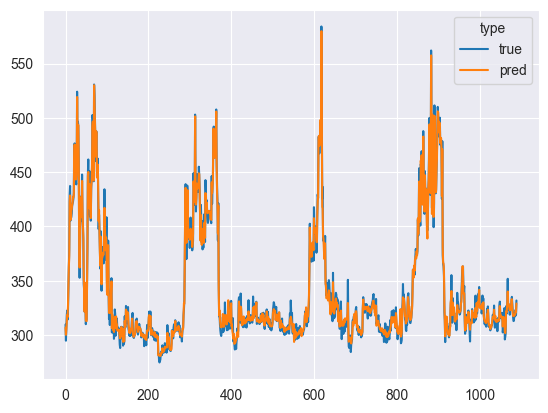

In [85]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [86]:
r2_score(y, predictions)

0.9925962004464751

In [87]:
for real, pred in zip(y, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 408.524472, pred: 380.5056932927155, diff: 28.018778707284525
real: 350.87063, pred: 329.5642571775999, diff: 21.30637282240008


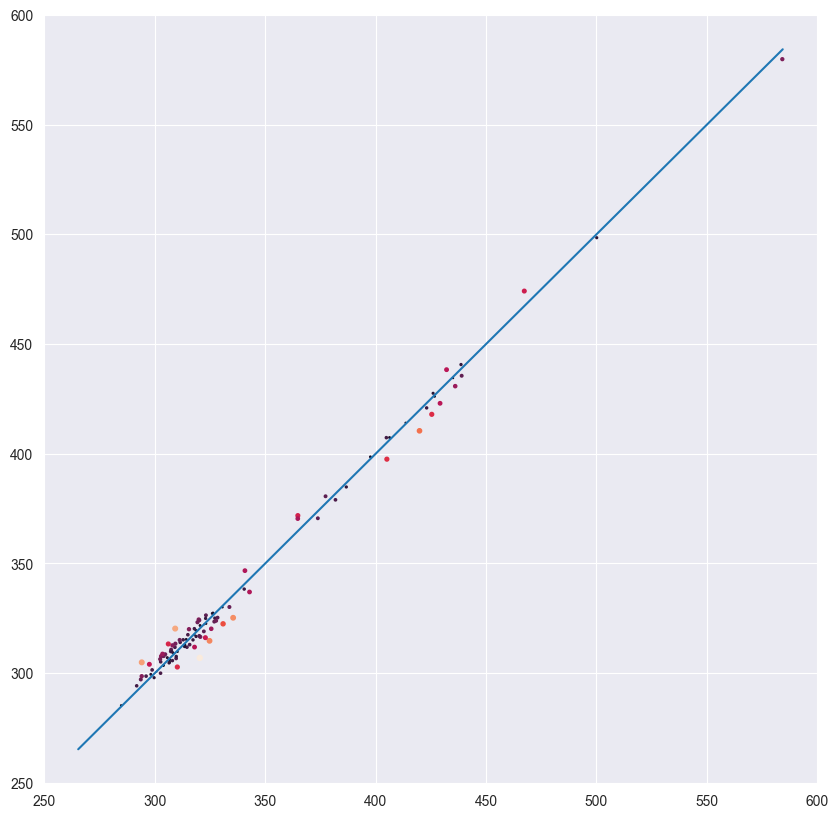

In [88]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [89]:
if not os.path.isdir("models"):
    os.mkdir("models")

In [90]:
with open("models/cat_boost_fuelTA130_09924.bf", "+wb") as file:
    pickle.dump(model, file)